Install and load packages

In [73]:
!pip install shap -qq
!pip install sweetviz -qq

In [74]:

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap
import urllib.request
import gzip
import sweetviz as sv
from sklearn.model_selection import train_test_split

Download data

In [75]:
#city listing summary adress url
URL_SOURCE = 'http://data.insideairbnb.com/spain/andaluc%C3%ADa/sevilla/2022-09-26/data/listings.csv.gz'

#download file
urllib.request.urlretrieve(URL_SOURCE, 'listings.csv.gz')

#open file csv.gz and read
with gzip.open('listings.csv.gz', 'rb') as f:
    file_content = f.read()

with open('sevilla_listings.csv', 'wb') as f:
    f.write(file_content)

In [76]:
#read data into dataframe
data_frame = pd.read_csv('sevilla_listings.csv')
data_frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6494 entries, 0 to 6493
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6494 non-null   int64  
 1   listing_url                                   6494 non-null   object 
 2   scrape_id                                     6494 non-null   int64  
 3   last_scraped                                  6494 non-null   object 
 4   source                                        6494 non-null   object 
 5   name                                          6494 non-null   object 
 6   description                                   6491 non-null   object 
 7   neighborhood_overview                         4161 non-null   object 
 8   picture_url                                   6494 non-null   object 
 9   host_id                                       6494 non-null   i

Basic report

In [78]:
report = sv.analyze(data_frame, pairwise_analysis='off')
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Select atributes

In [79]:
selected_columns = ['price','bathrooms_text','accommodates','bedrooms','review_scores_cleanliness', 'amenities']
#and check their types
data_frame[selected_columns].dtypes

price                         object
bathrooms_text                object
accommodates                   int64
bedrooms                     float64
review_scores_cleanliness    float64
amenities                     object
dtype: object

In [80]:
data_frame[selected_columns].describe
data_frame[selected_columns].head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities
0,$99.00,1 bath,4,2.0,4.96,"[""TV"", ""Washer"", ""Bedroom comforts"", ""Elevator..."
1,$75.00,1 bath,3,1.0,4.97,"[""Shampoo"", ""Clothing storage: closet"", ""Air c..."
2,$79.00,1 shared bath,2,1.0,4.31,"[""Shampoo"", ""Air conditioning"", ""Refrigerator""..."
3,$84.00,1 bath,6,2.0,4.82,"[""Shampoo"", ""Bathtub"", ""45\"" HDTV with Chromec..."
4,$85.00,1 bath,6,2.0,4.64,"[""Shampoo"", ""Outdoor dining area"", ""Private fe..."


In [81]:
#check missing values
data_frame[selected_columns].isna().sum()

price                          0
bathrooms_text                 8
accommodates                   0
bedrooms                     316
review_scores_cleanliness    751
amenities                      0
dtype: int64

In [82]:
#remove NaN values
data = data_frame[selected_columns].dropna()
data.head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities
0,$99.00,1 bath,4,2.0,4.96,"[""TV"", ""Washer"", ""Bedroom comforts"", ""Elevator..."
1,$75.00,1 bath,3,1.0,4.97,"[""Shampoo"", ""Clothing storage: closet"", ""Air c..."
2,$79.00,1 shared bath,2,1.0,4.31,"[""Shampoo"", ""Air conditioning"", ""Refrigerator""..."
3,$84.00,1 bath,6,2.0,4.82,"[""Shampoo"", ""Bathtub"", ""45\"" HDTV with Chromec..."
4,$85.00,1 bath,6,2.0,4.64,"[""Shampoo"", ""Outdoor dining area"", ""Private fe..."


In [83]:
#remove "" 
data.amenities = data_frame.amenities.apply(lambda x: x.replace('"',''))

#select interesting attributes form 'amenities' column
list_amenities = ['Air conditioning', 'Wifi', 'Kitchen', 'Microwave']

def separateAmenities(record):
  '''#slice each into a separate column, 
  add label True or False, change type to bool
  '''
  data[f"{record}"] = ''
  for index, row in data.iterrows():
    if f'{record}' in row.amenities:
      data.at[index, f'{record}'] = True
    else:
      data.at[index, f'{record}'] = False
    data[f'{record}'] = data[f'{record}'].astype(bool)

for each in list_amenities:
  separateAmenities(each)


In [84]:
#remove ' ' from column name
data.rename(columns={'Air conditioning': 'Air_conditioning'}, inplace=True)
data.columns

Index(['price', 'bathrooms_text', 'accommodates', 'bedrooms',
       'review_scores_cleanliness', 'amenities', 'Air_conditioning', 'Wifi',
       'Kitchen', 'Microwave'],
      dtype='object')

In [85]:
#cast price as float
data.price = data.price.apply(lambda x: x.replace('$',''))
data.price = data.price.apply(lambda x: x.replace(',',''))
data.price = pd.to_numeric(data.price, errors='coerce')
data.price.describe()

count    5468.000000
mean      133.179225
std       265.710509
min         9.000000
25%        68.000000
50%        98.000000
75%       142.000000
max      8000.000000
Name: price, dtype: float64

In [94]:
# Getting rid of outliers
print("99.5% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99.5)))
data = data[(data.price <= np.percentile(data.price, 99.5)) & (data.price > 0)]

99.5% properties have a price lower than  298.71


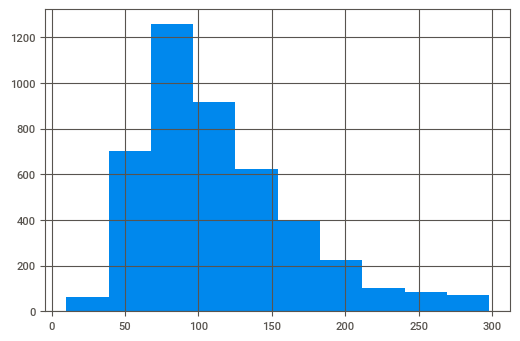

In [101]:
data.price.hist()

In [102]:
#replace number of bathrooms and change to int
data.bathrooms_text.unique()

array(['1 bath', '1.5 baths', '2 baths', '3 baths', '3.5 baths',
       '2.5 baths', '6 baths', '4 baths', '4.5 baths', '15.5 baths',
       '0 baths'], dtype=object)

In [103]:
#take unique values from column bathrooms_text
bathrooms_options_list = ['1 bath','1.5 baths','2 baths',
                          '3 baths','3.5 baths','2.5 baths','4 baths','5 baths',
                          '7.5 baths', '6 baths', '4.5 baths','5.5 baths',
                          '15.5 baths','6.5 baths', '13.5 baths', '7 baths', '0 baths']

#drop rows with values different than in list above
data.drop(data[~data['bathrooms_text'].isin(bathrooms_options_list)].index, inplace=True)


In [104]:
#get numbers from column bathroom_text
data[['bathrooms_number','bathrooms_text2']] = data.bathrooms_text.str.split('b',expand=True)
data.drop('bathrooms_text2', inplace=True, axis=1)
data.bathrooms_number.unique()

array(['1 ', '1.5 ', '2 ', '3 ', '3.5 ', '2.5 ', '6 ', '4 ', '4.5 ',
       '15.5 ', '0 '], dtype=object)

In [105]:
#save column bathroom_number as float
data.bathrooms_number = data.bathrooms_number.astype(float)
data.head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities,Air_conditioning,Wifi,Kitchen,Microwave,bathrooms_number
0,99.0,1 bath,4,2.0,4.96,"[TV, Washer, Bedroom comforts, Elevator, Bathr...",True,True,False,False,1.0
1,75.0,1 bath,3,1.0,4.97,"[Shampoo, Clothing storage: closet, Air condit...",True,True,True,True,1.0
3,84.0,1 bath,6,2.0,4.82,"[Shampoo, Bathtub, 45\ HDTV with Chromecast, s...",False,True,True,True,1.0
4,85.0,1 bath,6,2.0,4.64,"[Shampoo, Outdoor dining area, Private fenced ...",False,True,True,True,1.0
5,83.0,1 bath,4,1.0,4.68,"[Shampoo, Private fenced garden or backyard, R...",False,True,True,True,1.0


Modelling

In [107]:
model = smf.ols('price ~ accommodates + bedrooms + review_scores_cleanliness + bathrooms_number + Wifi + Air_conditioning + Kitchen + Microwave', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     187.8
Date:                Wed, 28 Dec 2022   Prob (F-statistic):          3.63e-274
Time:                        20:08:37   Log-Likelihood:                -23268.
No. Observations:                4444   AIC:                         4.655e+04
Df Residuals:                    4435   BIC:                         4.661e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Lasso

(0.0006975725383492845,
 37.559722109872254,
 -2.395797997521283,
 16.95317707030741)

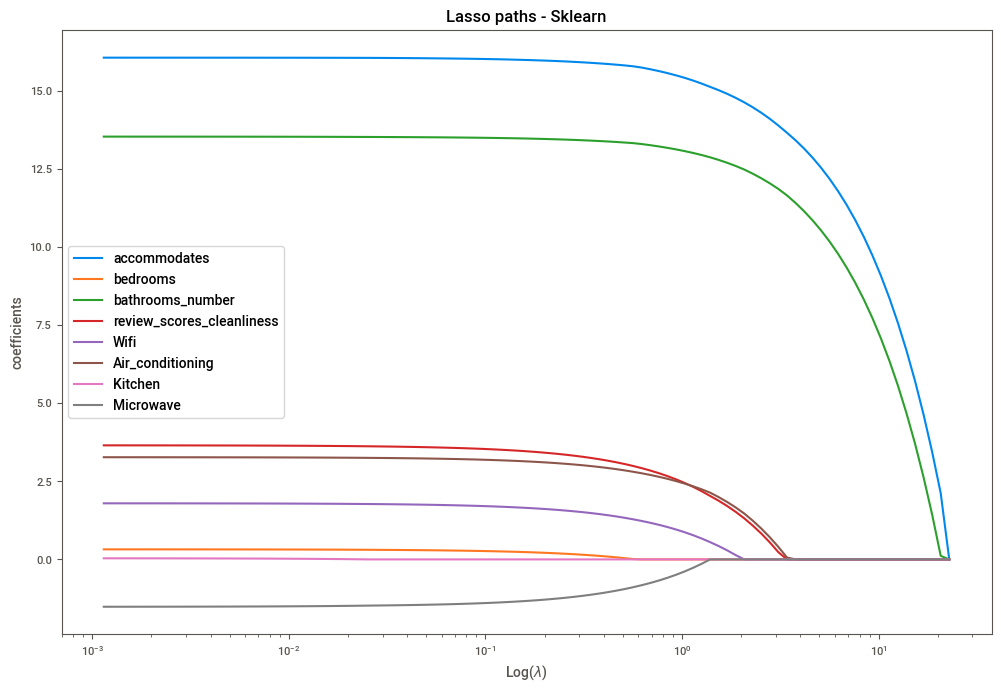

In [108]:
variables = ['accommodates', 'bedrooms', 'bathrooms_number', 'review_scores_cleanliness', 'Wifi', 'Air_conditioning', 'Kitchen', 'Microwave']

data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

xgBoost

In [110]:
# XGBoost

variables = ['accommodates', 'bedrooms', 'bathrooms_number', 'review_scores_cleanliness', 'Wifi', 'Air_conditioning', 'Kitchen', 'Microwave']
data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:100000,:]

X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = xgboost.XGBRegressor(n_estimators=1000, verbosity=1)
model.fit(X_train, y_train)

[20:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [111]:
predicted = model.predict(X_test)
mean_squared_error(y_test, predicted)

2163.0323479615595

Shapley

In [112]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
X.iloc[0,:]

accommodates                    4
bedrooms                      2.0
bathrooms_number              1.0
review_scores_cleanliness    4.96
Wifi                         True
Air_conditioning             True
Name: 0, dtype: object

In [113]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

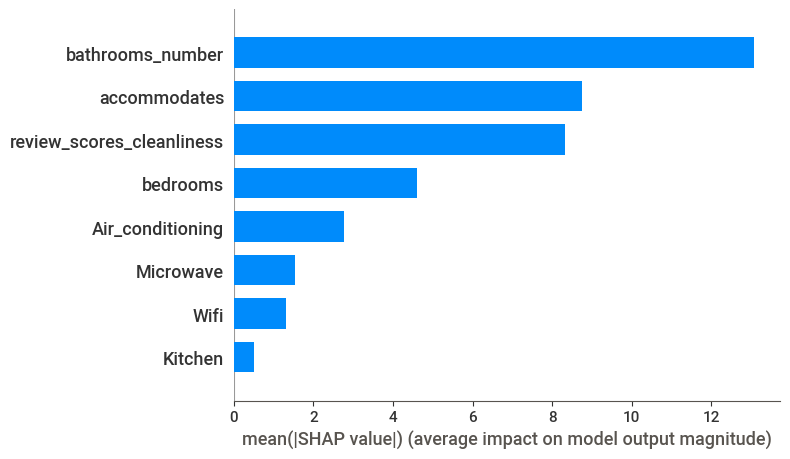

In [114]:
shap.summary_plot(shap_values, X, plot_type="bar")

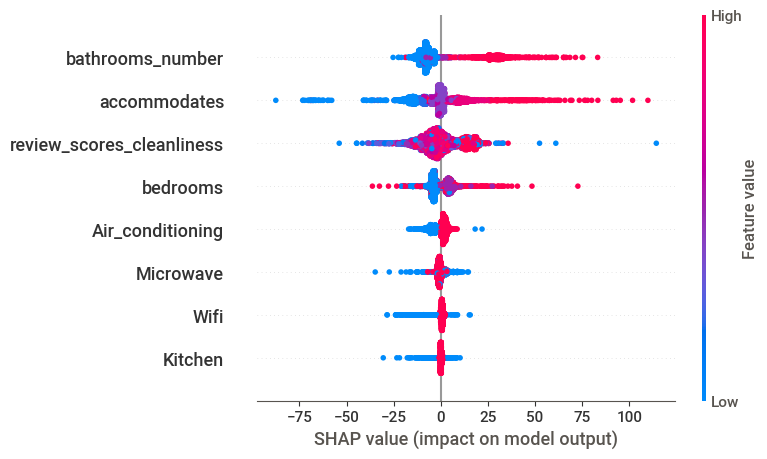

In [115]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)